In [ ]:
# --- Colab + project setup (run once) ---
from google.colab import drive
drive.mount('/content/drive')

import os, sys, torch, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
print("PyTorch:", torch.__version__)

# Path to your project on Drive
PROJECT_DIR = "/content/drive/MyDrive/Benchmarking_UQ"  # <- matches your folder name
assert os.path.isdir(PROJECT_DIR), f"Not found: {PROJECT_DIR}"

# Make project importable and set CWD
sys.path.append(PROJECT_DIR)
os.chdir(PROJECT_DIR)
print("CWD:", os.getcwd())

# Create a results folder
os.makedirs("results", exist_ok=True)

# Imports from your repo
from utils.models import get_pretrained_model
from utils.dataloader import get_cifar10_loader, get_cifar100_loader, get_svhn_loader, get_tinyimagenet_loader
from uq.methods import predict_vanilla, predict_mc_dropout, predict_tta
from uq.metrics import expected_calibration_error, predictive_entropy, max_probability

# Speed preset S
BATCH_SIZE = 128
MC_PASSES  = 5
TTA_PASSES = 5
DROPOUT_P  = 0.2  # injected before classifier head for MC Dropout

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Mounted at /content/drive
PyTorch: 2.8.0+cu126
CWD: /content/drive/MyDrive/Benchmarking_UQ
Device: cuda


In [ ]:
from sklearn.metrics import roc_auc_score

def compute_auc(id_scores, ood_scores, higher_is_uncertain=True):
    y_true = [0]*len(id_scores) + [1]*len(ood_scores)
    scores = torch.cat([id_scores, ood_scores]).cpu().numpy()

    # invert score if low = more uncertain (MaxProb)
    if not higher_is_uncertain:
        scores = -scores

    return roc_auc_score(y_true, scores)


In [ ]:
# Helper to evaluate one model across all datasets and UQ methods
def run_model(model_name: str, save_csv_path: str):
    import pandas as pd

    # Load model + required input size (e.g., 224 or 384)
    model, img_size = get_pretrained_model(model_name, dropout_p=DROPOUT_P, device=device)

    # Non-TTA loaders (baseline + MC Dropout)
    loaders = {
        "CIFAR-10":  get_cifar10_loader(BATCH_SIZE, img_size, tta=False),
        "CIFAR-100": get_cifar100_loader(BATCH_SIZE, img_size, tta=False),
        "SVHN":      get_svhn_loader(BATCH_SIZE, img_size, tta=False),
    }

    rows = []

    #  Vanilla baseline
    for dname, loader in loaders.items():
        probs, labels = predict_vanilla(model, loader, device)
        ece = expected_calibration_error(probs, labels)
        ent = float(predictive_entropy(probs).mean().item())
        mp  = float(max_probability(probs).mean().item())
        rows.append({"model": model_name, "dataset": dname, "uq_method": "Vanilla",
                     "ECE": ece, "AvgEntropy": ent, "AvgMaxProb": mp})

    #  MC Dropout
    for dname, loader in loaders.items():
        probs, _, labels = predict_mc_dropout(model, loader, device, T=MC_PASSES)
        ece = expected_calibration_error(probs, labels)
        ent = float(predictive_entropy(probs).mean().item())
        mp  = float(max_probability(probs).mean().item())
        rows.append({"model": model_name, "dataset": dname, "uq_method": "MC Dropout",
                     "ECE": ece, "AvgEntropy": ent, "AvgMaxProb": mp})

    #  TTA (create TTA loaders per dataset)
    for dname in ["CIFAR-10", "CIFAR-100", "SVHN"]:
        if dname == "CIFAR-10":
            tta_loader = get_cifar10_loader(BATCH_SIZE, img_size, tta=True)
        elif dname == "CIFAR-100":
            tta_loader = get_cifar100_loader(BATCH_SIZE, img_size, tta=True)
        else:
            tta_loader = get_svhn_loader(BATCH_SIZE, img_size, tta=True)

        probs, _, labels = predict_tta(model, tta_loader, device, T=TTA_PASSES)
        ece = expected_calibration_error(probs, labels)
        ent = float(predictive_entropy(probs).mean().item())
        mp  = float(max_probability(probs).mean().item())
        rows.append({"model": model_name, "dataset": dname, "uq_method": "TTA",
                     "ECE": ece, "AvgEntropy": ent, "AvgMaxProb": mp})

    df = pd.DataFrame(rows)
    df.to_csv(save_csv_path, index=False)
    print(f"Saved: {save_csv_path}")
    return df

In [ ]:
def run_model_auc(model_name: str, save_csv_path: str):
    import os
    os.makedirs(os.path.dirname(save_csv_path), exist_ok=True)

    print(f"\n====== AUC EVAL | MODEL: {model_name} ======")

    model, img_size = get_pretrained_model(model_name, dropout_p=DROPOUT_P, device=device)

    id_loader = get_tinyimagenet_loader(BATCH_SIZE, img_size, tta=False)
    ood_loaders = {
        "CIFAR-10":  get_cifar10_loader(BATCH_SIZE, img_size, tta=False),
        "CIFAR-100": get_cifar100_loader(BATCH_SIZE, img_size, tta=False),
        "SVHN":      get_svhn_loader(BATCH_SIZE, img_size, tta=False),
    }

    # Try to resume
    if os.path.exists(save_csv_path):
        df = pd.read_csv(save_csv_path)
        rows = df.to_dict("records")
        print("Resuming previous results...")
    else:
        rows = []

    for uq_method in ["Vanilla", "MC Dropout", "TTA"]:
        print(f"\n--- UQ METHOD: {uq_method} ---")

        if uq_method == "Vanilla":
            pred_fn = predict_vanilla
            kwargs = {}
        elif uq_method == "MC Dropout":
            pred_fn = predict_mc_dropout
            kwargs = {"T": MC_PASSES}
        else:
            pred_fn = predict_tta
            kwargs = {"T": TTA_PASSES}

        # Skip methods already done
        done_methods = {r["uq_method"] for r in rows}
        if uq_method in done_methods:
            print(f"{uq_method} already completed. Skipping...")
            continue

        # ID predictions
        id_out = pred_fn(model, id_loader, device, **kwargs)
        id_probs, id_labels = id_out if len(id_out)==2 else (id_out[0], id_out[2])

        id_ent = predictive_entropy(id_probs)
        id_mp  = max_probability(id_probs)

        for dname, ood_loader in ood_loaders.items():

            ood_out = pred_fn(model, ood_loader, device, **kwargs)
            ood_probs, ood_labels = ood_out if len(ood_out)==2 else (ood_out[0], ood_out[2])

            ood_ent = predictive_entropy(ood_probs)
            ood_mp  = max_probability(ood_probs)

            auc_ent = compute_auc(id_ent, ood_ent, higher_is_uncertain=True)
            auc_mp  = compute_auc(id_mp, ood_mp, higher_is_uncertain=False)

            rows.append({
                "model": model_name,
                "uq_method": uq_method,
                "ood_dataset": dname,
                "AUC_Entropy": auc_ent,
                "AUC_MaxProb": auc_mp,
            })

            # ---- SAVE AFTER EACH DATASET ----
            pd.DataFrame(rows).to_csv(save_csv_path, index=False)
            print(f"Saved progress → {save_csv_path}")

    df = pd.DataFrame(rows)
    print(f"\nFINISHED: {save_csv_path}")
    return df


In [ ]:
res18_csv = "results/resnet18_results.csv"
df_res18 = run_model("resnet18", res18_csv)
df_res18

Saved: results/resnet18_results.csv


,model,dataset,uq_method,ECE,AvgEntropy,AvgMaxProb
0,resnet18,CIFAR-10,Vanilla,0.371177,2.872074,0.371177
1,resnet18,CIFAR-100,Vanilla,0.327182,3.177649,0.330982
2,resnet18,SVHN,Vanilla,0.104538,4.825012,0.104538
3,resnet18,CIFAR-10,MC Dropout,0.331586,3.040489,0.331586
4,resnet18,CIFAR-100,MC Dropout,0.293703,3.309496,0.297703
5,resnet18,SVHN,MC Dropout,0.105610,4.833997,0.105610
6,resnet18,CIFAR-10,TTA,0.344710,3.035383,0.344710
7,resnet18,CIFAR-100,TTA,0.303993,3.315380,0.307693
8,resnet18,SVHN,TTA,0.095757,4.924401,0.095757


In [ ]:
res34_csv = "results/resnet34_results.csv"
df_res34 = run_model("resnet34", res34_csv)
df_res34


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 181MB/s]


Saved: results/resnet34_results.csv


,model,dataset,uq_method,ECE,AvgEntropy,AvgMaxProb
0,resnet34,CIFAR-10,Vanilla,0.441189,2.448144,0.441189
1,resnet34,CIFAR-100,Vanilla,0.390327,2.786687,0.394527
2,resnet34,SVHN,Vanilla,0.174001,4.255466,0.174001
3,resnet34,CIFAR-10,MC Dropout,0.388040,2.673412,0.388040
4,resnet34,CIFAR-100,MC Dropout,0.344002,2.966392,0.348302
5,resnet34,SVHN,MC Dropout,0.165342,4.326387,0.165342
6,resnet34,CIFAR-10,TTA,0.409292,2.621043,0.409292
7,resnet34,CIFAR-100,TTA,0.364125,2.926167,0.368525
8,resnet34,SVHN,TTA,0.163799,4.333647,0.163799


In [ ]:
vgg_csv = "results/vgg16_bn_results.csv"
df_vgg = run_model("vgg16_bn", vgg_csv)
df_vgg


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


100%|██████████| 528M/528M [00:03<00:00, 161MB/s]


Saved: results/vgg16_bn_results.csv


,model,dataset,uq_method,ECE,AvgEntropy,AvgMaxProb
0,vgg16_bn,CIFAR-10,Vanilla,0.333770,3.108065,0.333770
1,vgg16_bn,CIFAR-100,Vanilla,0.305053,3.325610,0.308453
2,vgg16_bn,SVHN,Vanilla,0.079802,5.165131,0.079802
3,vgg16_bn,CIFAR-10,MC Dropout,0.299363,3.275948,0.299463
4,vgg16_bn,CIFAR-100,MC Dropout,0.277102,3.446231,0.280702
5,vgg16_bn,SVHN,MC Dropout,0.081959,5.129828,0.081959
6,vgg16_bn,CIFAR-10,TTA,0.306609,3.285024,0.306709
7,vgg16_bn,CIFAR-100,TTA,0.284253,3.466230,0.287453
8,vgg16_bn,SVHN,TTA,0.073703,5.238557,0.073703


In [ ]:
eff_csv = "results/efficientnet_v2_s_results.csv"
df_eff = run_model("efficientnet_v2_s", eff_csv)
df_eff


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 202MB/s]


Saved: results/efficientnet_v2_s_results.csv


,model,dataset,uq_method,ECE,AvgEntropy,AvgMaxProb
0,efficientnet_v2_s,CIFAR-10,Vanilla,0.343374,3.957811,0.343374
1,efficientnet_v2_s,CIFAR-100,Vanilla,0.310183,4.147372,0.314583
2,efficientnet_v2_s,SVHN,Vanilla,0.161154,4.991233,0.161192
3,efficientnet_v2_s,CIFAR-10,MC Dropout,0.335110,4.002607,0.335110
4,efficientnet_v2_s,CIFAR-100,MC Dropout,0.302765,4.183912,0.306965
5,efficientnet_v2_s,SVHN,MC Dropout,0.159798,4.987522,0.159836
6,efficientnet_v2_s,CIFAR-10,TTA,0.329006,4.033824,0.329006
7,efficientnet_v2_s,CIFAR-100,TTA,0.299444,4.206904,0.303844
8,efficientnet_v2_s,SVHN,TTA,0.151188,5.068027,0.151188


In [ ]:
conv_csv = "results/convnext_tiny_results.csv"
df_conv = run_model("convnext_tiny", conv_csv)
df_conv


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


100%|██████████| 109M/109M [00:00<00:00, 128MB/s]


Saved: results/convnext_tiny_results.csv


,model,dataset,uq_method,ECE,AvgEntropy,AvgMaxProb
0,convnext_tiny,CIFAR-10,Vanilla,0.328742,3.945378,0.328742
1,convnext_tiny,CIFAR-100,Vanilla,0.298231,4.092923,0.302831
2,convnext_tiny,SVHN,Vanilla,0.105758,5.390488,0.105758
3,convnext_tiny,CIFAR-10,MC Dropout,0.320857,4.002265,0.320857
4,convnext_tiny,CIFAR-100,MC Dropout,0.291346,4.142957,0.295746
5,convnext_tiny,SVHN,MC Dropout,0.104532,5.397663,0.104532
6,convnext_tiny,CIFAR-10,TTA,0.318607,3.994264,0.318607
7,convnext_tiny,CIFAR-100,TTA,0.291877,4.127909,0.296477
8,convnext_tiny,SVHN,TTA,0.097079,5.470205,0.097079


In [ ]:
import pandas as pd, glob, seaborn as sns, matplotlib.pyplot as plt

all_csvs = sorted(glob.glob("results/*_results.csv"))
print("Found CSVs:", all_csvs)

dfs = [pd.read_csv(p) for p in all_csvs]
full_df = pd.concat(dfs, ignore_index=True)
full_df.to_csv("results/_all_models_combined.csv", index=False)

print("Combined saved to results/_all_models_combined.csv")
display(full_df.head())

# Set style
sns.set(style="whitegrid")

Found CSVs: ['results/convnext_tiny_results.csv', 'results/efficientnet_v2_s_results.csv', 'results/resnet18_results.csv', 'results/resnet34_results.csv', 'results/vgg16_bn_results.csv']
Combined saved to results/_all_models_combined.csv


,model,dataset,uq_method,ECE,AvgEntropy,AvgMaxProb
0,convnext_tiny,CIFAR-10,Vanilla,0.328742,3.945378,0.328742
1,convnext_tiny,CIFAR-100,Vanilla,0.298231,4.092923,0.302831
2,convnext_tiny,SVHN,Vanilla,0.105758,5.390488,0.105758
3,convnext_tiny,CIFAR-10,MC Dropout,0.320857,4.002265,0.320857
4,convnext_tiny,CIFAR-100,MC Dropout,0.291346,4.142957,0.295746


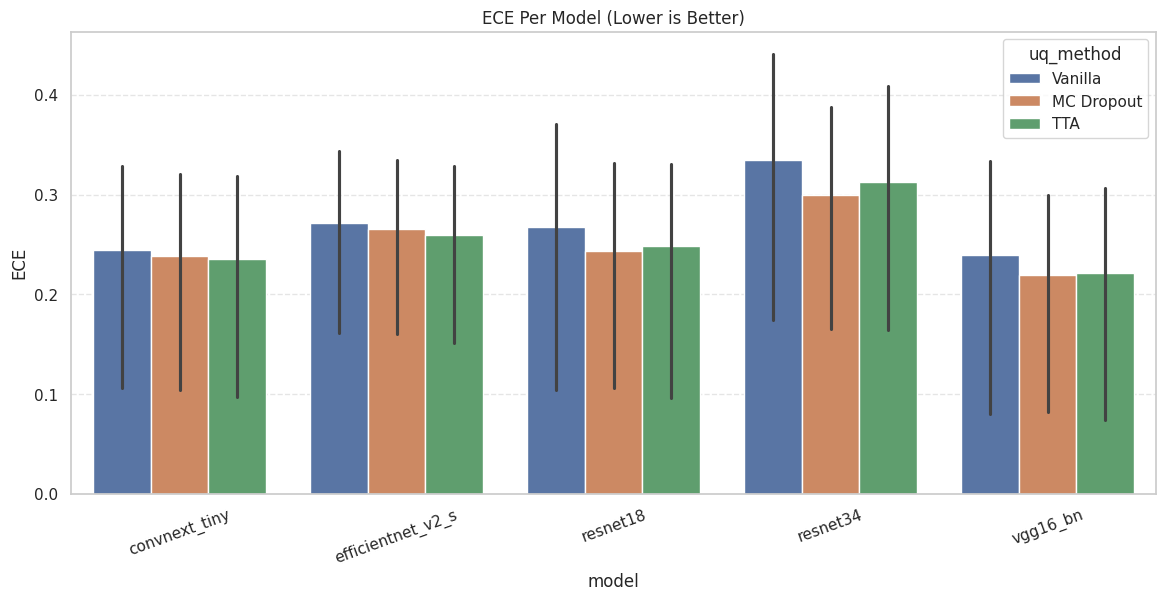

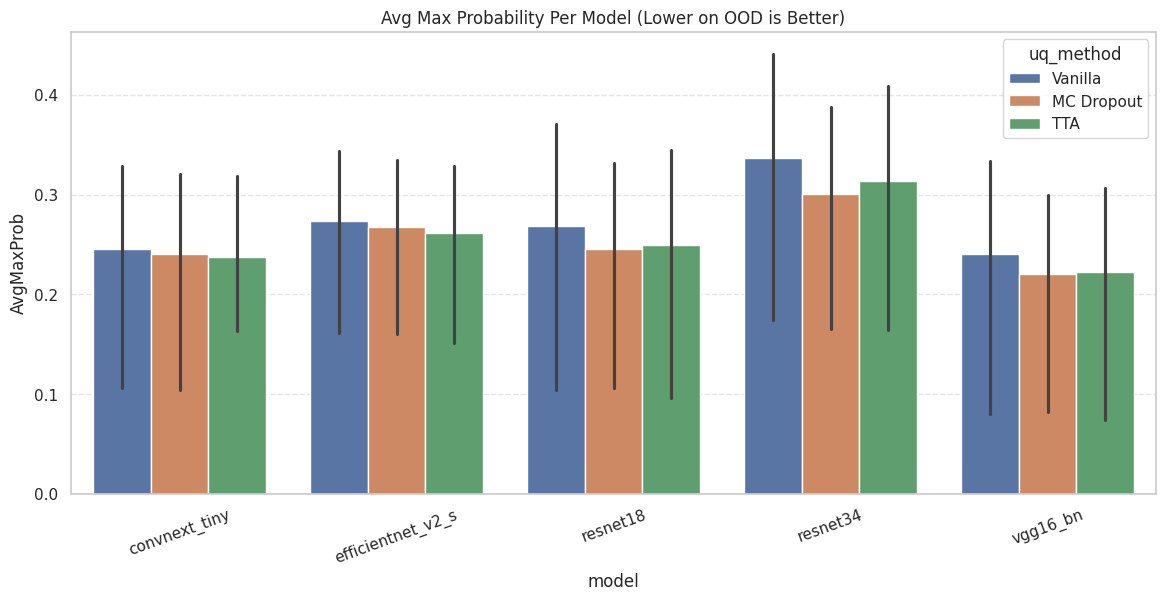

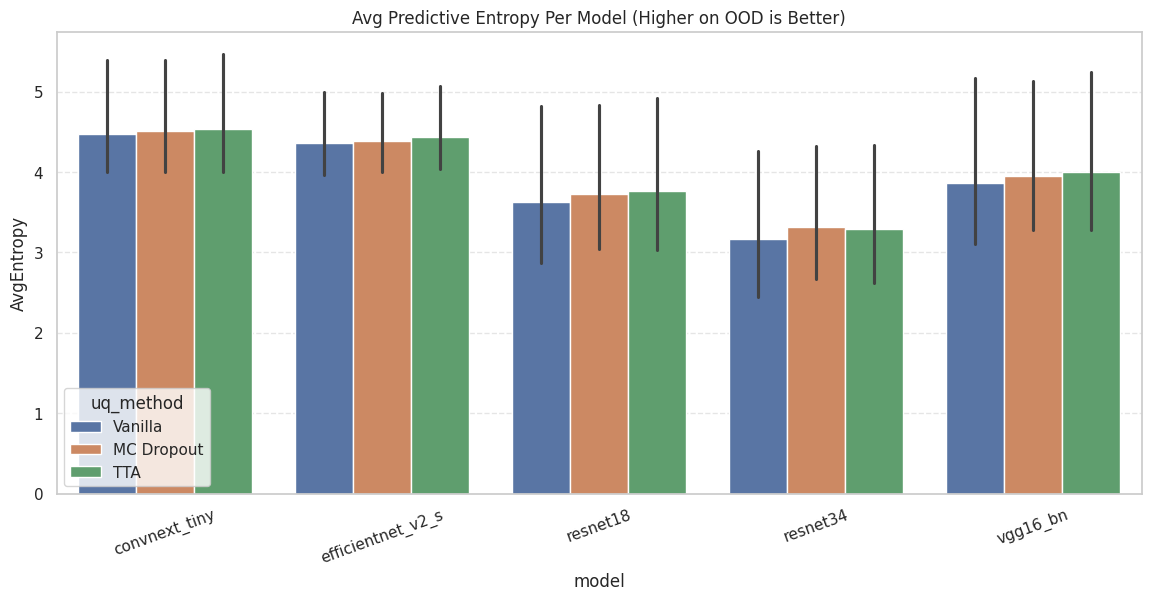

In [ ]:
plt.figure(figsize=(14,6))
sns.barplot(data=full_df, x="model", y="ECE", hue="uq_method")
plt.title("ECE Per Model (Lower is Better)")
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

plt.figure(figsize=(14,6))
sns.barplot(data=full_df, x="model", y="AvgMaxProb", hue="uq_method")
plt.title("Avg Max Probability Per Model (Lower on OOD is Better)")
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

plt.figure(figsize=(14,6))
sns.barplot(data=full_df, x="model", y="AvgEntropy", hue="uq_method")
plt.title("Avg Predictive Entropy Per Model (Higher on OOD is Better)")
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

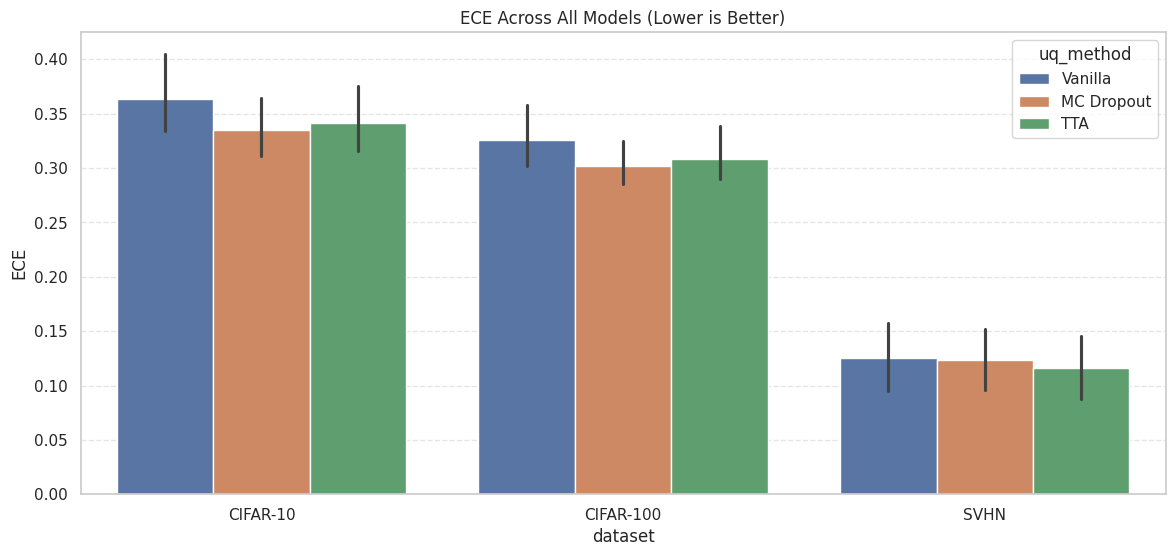

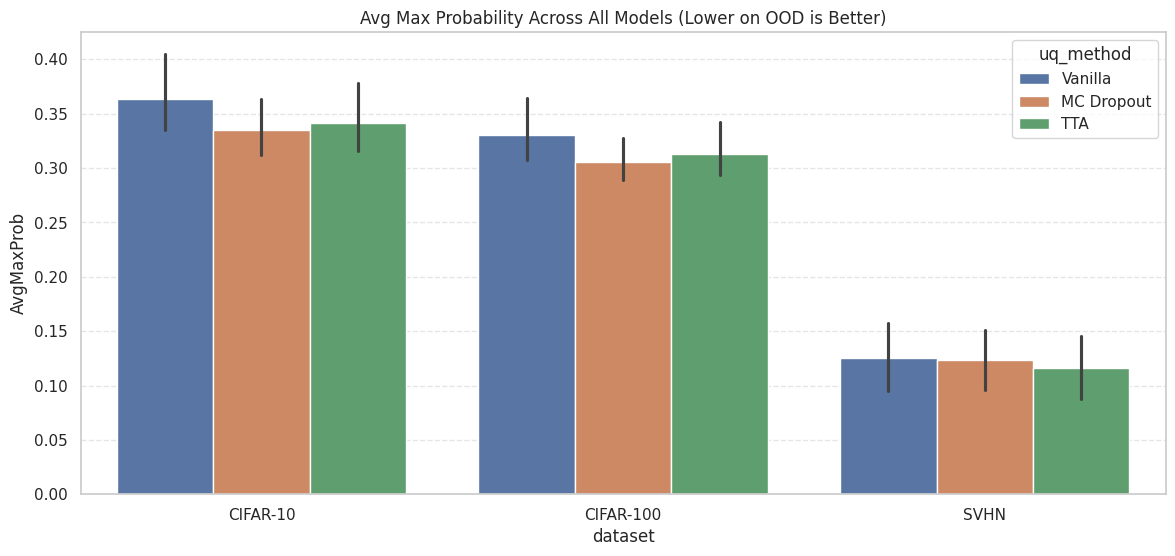

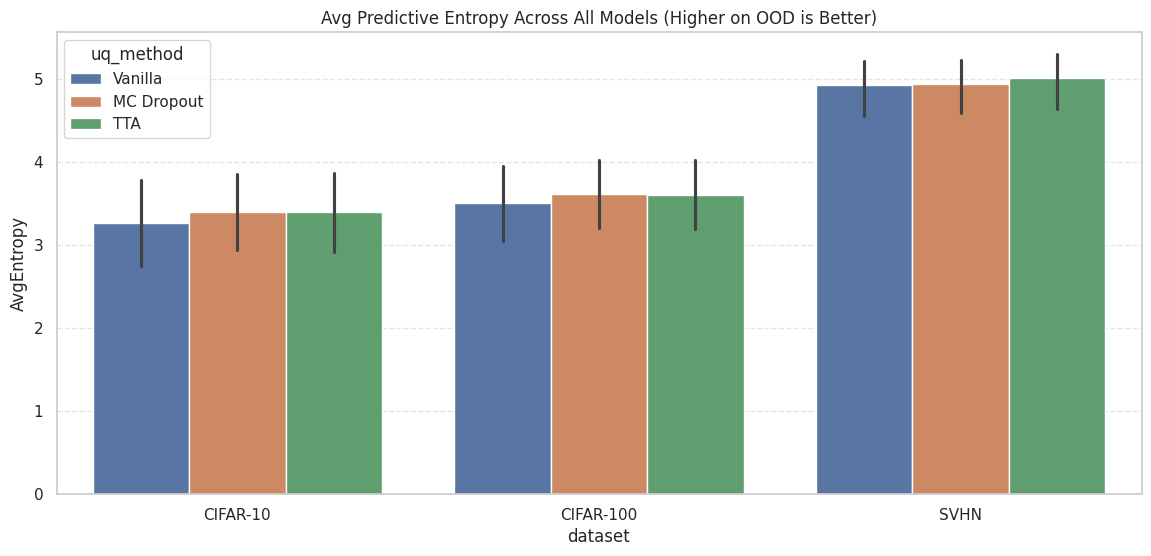

In [ ]:
plt.figure(figsize=(14,6))
sns.barplot(data=full_df, x="dataset", y="ECE", hue="uq_method")
plt.title("ECE Across All Models (Lower is Better)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

plt.figure(figsize=(14,6))
sns.barplot(data=full_df, x="dataset", y="AvgMaxProb", hue="uq_method")
plt.title("Avg Max Probability Across All Models (Lower on OOD is Better)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

plt.figure(figsize=(14,6))
sns.barplot(data=full_df, x="dataset", y="AvgEntropy", hue="uq_method")
plt.title("Avg Predictive Entropy Across All Models (Higher on OOD is Better)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


In [ ]:
# Remove any old temporary folders
!rm -rf /content/tiny-imagenet-200

# Extract locally (VERY FAST)
!unzip -q "/content/drive/MyDrive/Benchmarking_UQ/tiny-imagenet-200.zip" -d /content/


In [ ]:
import os, shutil

SRC = "/content/tiny-imagenet-200/val"
DST = "/content/tiny-imagenet-200/val_fixed"

# Clean target
shutil.rmtree(DST, ignore_errors=True)
os.makedirs(DST, exist_ok=True)

# Load annotations
ann_path = os.path.join(SRC, "val_annotations.txt")
with open(ann_path) as f:
    rows = [line.strip().split("\t") for line in f.readlines()]

# Create class folders & move images
for img, cls, *_ in rows:
    cls_dir = os.path.join(DST, cls)
    os.makedirs(cls_dir, exist_ok=True)

    src_img = os.path.join(SRC, "images", img)
    dst_img = os.path.join(cls_dir, img)

    shutil.copy(src_img, dst_img)

print("VAL FIXED SUCCESSFULLY!")


VAL FIXED SUCCESSFULLY!


In [ ]:
df_res18_auc = run_model_auc("resnet18", "results_auc/resnet18_auc.csv")
df_res18_auc


====== AUC EVAL | MODEL: resnet18 ======

--- UQ METHOD: Vanilla ---


Saved progress → results_auc/resnet18_auc.csv


Saved progress → results_auc/resnet18_auc.csv


Saved progress → results_auc/resnet18_auc.csv

--- UQ METHOD: MC Dropout ---


Saved progress → results_auc/resnet18_auc.csv


Saved progress → results_auc/resnet18_auc.csv


Saved progress → results_auc/resnet18_auc.csv

--- UQ METHOD: TTA ---


Saved progress → results_auc/resnet18_auc.csv


Saved progress → results_auc/resnet18_auc.csv


Saved progress → results_auc/resnet18_auc.csv

FINISHED: results_auc/resnet18_auc.csv


,model,uq_method,ood_dataset,AUC_Entropy,AUC_MaxProb
0,resnet18,Vanilla,CIFAR-10,0.525176,0.530020
1,resnet18,Vanilla,CIFAR-100,0.590523,0.581985
2,resnet18,Vanilla,SVHN,0.928251,0.903464
3,resnet18,MC Dropout,CIFAR-10,0.527047,0.526763
4,resnet18,MC Dropout,CIFAR-100,0.590661,0.576498
5,resnet18,MC Dropout,SVHN,0.927560,0.894188
6,resnet18,TTA,CIFAR-10,0.525176,0.530020
7,resnet18,TTA,CIFAR-100,0.590523,0.581985
8,resnet18,TTA,SVHN,0.928251,0.903464


In [ ]:
df_vgg16_auc = run_model_auc("vgg16_bn", "results_auc/vgg16_bn_auc.csv")
df_vgg16_auc



====== AUC EVAL | MODEL: vgg16_bn ======
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


100%|██████████| 528M/528M [00:06<00:00, 85.4MB/s]



--- UQ METHOD: Vanilla ---


Saved progress → results_auc/vgg16_bn_auc.csv


Saved progress → results_auc/vgg16_bn_auc.csv


Saved progress → results_auc/vgg16_bn_auc.csv

--- UQ METHOD: MC Dropout ---


Saved progress → results_auc/vgg16_bn_auc.csv


Saved progress → results_auc/vgg16_bn_auc.csv


Saved progress → results_auc/vgg16_bn_auc.csv

--- UQ METHOD: TTA ---


Saved progress → results_auc/vgg16_bn_auc.csv


Saved progress → results_auc/vgg16_bn_auc.csv


Saved progress → results_auc/vgg16_bn_auc.csv

FINISHED: results_auc/vgg16_bn_auc.csv


,model,uq_method,ood_dataset,AUC_Entropy,AUC_MaxProb
0,vgg16_bn,Vanilla,CIFAR-10,0.581314,0.573753
1,vgg16_bn,Vanilla,CIFAR-100,0.626251,0.605856
2,vgg16_bn,Vanilla,SVHN,0.958279,0.938001
3,vgg16_bn,MC Dropout,CIFAR-10,0.587546,0.577145
4,vgg16_bn,MC Dropout,CIFAR-100,0.626094,0.603417
5,vgg16_bn,MC Dropout,SVHN,0.954338,0.930473
6,vgg16_bn,TTA,CIFAR-10,0.581314,0.573753
7,vgg16_bn,TTA,CIFAR-100,0.626251,0.605856
8,vgg16_bn,TTA,SVHN,0.958279,0.938001


In [ ]:
df_convnext_tiny_auc = run_model_auc("convnext_tiny", "results_auc/convnext_tiny.csv")
df_convnext_tiny_auc


====== AUC EVAL | MODEL: convnext_tiny ======

--- UQ METHOD: Vanilla ---


Saved progress → results_auc/convnext_tiny.csv


Saved progress → results_auc/convnext_tiny.csv


Saved progress → results_auc/convnext_tiny.csv

--- UQ METHOD: MC Dropout ---


Saved progress → results_auc/convnext_tiny.csv


Saved progress → results_auc/convnext_tiny.csv


Saved progress → results_auc/convnext_tiny.csv

--- UQ METHOD: TTA ---


Saved progress → results_auc/convnext_tiny.csv


Saved progress → results_auc/convnext_tiny.csv


Saved progress → results_auc/convnext_tiny.csv

FINISHED: results_auc/convnext_tiny.csv


,model,uq_method,ood_dataset,AUC_Entropy,AUC_MaxProb
0,convnext_tiny,Vanilla,CIFAR-10,0.597837,0.589506
1,convnext_tiny,Vanilla,CIFAR-100,0.629597,0.621388
2,convnext_tiny,Vanilla,SVHN,0.938004,0.908127
3,convnext_tiny,MC Dropout,CIFAR-10,0.597868,0.590579
4,convnext_tiny,MC Dropout,CIFAR-100,0.628888,0.622006
5,convnext_tiny,MC Dropout,SVHN,0.935300,0.906694
6,convnext_tiny,TTA,CIFAR-10,0.597837,0.589506
7,convnext_tiny,TTA,CIFAR-100,0.629597,0.621388
8,convnext_tiny,TTA,SVHN,0.938004,0.908127
